In [0]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 2.1MB/s 


In [0]:
#####----Cornell NLP: Project X - Named Entity Recognition----#####
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
import re
import string
from collections import defaultdict
import torch
from torch import nn, optim
from torch.optim import Adam
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences #install
from pytorch_pretrained_bert import BertTokenizer, BertConfig #pip install pytorch_pretrained_bert
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam
import seaborn as sns
from sklearn.metrics import confusion_matrix
from joblib import dump, load
import time


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
## Load data
folder_url = "/gdrive/My Drive/Colab Notebooks/Data/NLP Project X/"
train_file = folder_url + "train/train.txt"#.readlines()
dev_file = folder_url + "dev/dev.txt"#.readlines()
test_file = folder_url + "test/test.nolabels.txt"#.readlines()

train_data = pd.read_csv(folder_url + "train/train.txt", names=['text','tag'], sep='\s+')
dev_data = pd.read_csv(folder_url + "dev/dev.txt", names=['text','tag'], sep='\s+', engine='python')
test_data = pd.read_csv(folder_url + "test/test.nolabels.txt", names=['text'], sep='\s+', engine='python')
 

def load_words(data_file):
    #data_file = train_file #debug
    words = []
    tags = []
    #reader = csv.reader(data_file, delimiter='\t')
    reader = open(data_file).readlines()
    for i, row in enumerate(reader):
        row = row.replace('\n','')
        row = row.split('\t')
        print(i,row)
        if len(row)==1:
            words.append(row[0])
            tags.append('')
        elif len(row)==2:
            words.append(row[0])
            tags.append(row[1])
    return words, tags

train_words, train_tags = load_words(train_file)
dev_words, dev_tags = load_words(dev_file)
test_words, _ = load_words(test_file)

#unique_tags = set(train_tags)
#unique_tags.discard('')
#unique_tags.add('X')
unique_tags = ['O','B','I']
tag_index = dict((tag, i) for i, tag in enumerate(unique_tags))
index_tag = dict((i, tag) for i, tag in enumerate(unique_tags))


# Make sentences
def get_sentences(words):
    sentence = []
    sentence_list = []
    for word in words:
        if word != '':
            sentence.append(word)
        else:
            sentence_list.append(sentence)
            sentence = []
    return sentence_list

train_sentences = get_sentences(train_words)
train_sent_tags = get_sentences(train_tags)
dev_sentences = get_sentences(dev_words)
dev_sent_tags = get_sentences(dev_tags)
test_sentences = get_sentences(test_words)       


## Tokenize
def tokenize_sentences(sentences, sentence_tags, tokenizer):
    #sentences = train_sentences
    #sentence_tags = train_sent_tags
    
    token_sentences = []
    label_sentences = []
    origin_sentences = []
    
    for j in range(0,len(sentences)):
        word_list = sentences[j]
        tag_list = sentence_tags[j]
        tokens = []
        tags = []
        origins = []
        
        for i, word in enumerate(word_list):
            print('sentence',j,'word',i)
            token = tokenizer.tokenize(word) #tokenize word according to BERT
            tokens.extend(token)
            tag = tag_list[i]
            # fit labels to tokenized size of word
            for m in range(len(token)):
                tags.append(tag)
                if m == 0:
                  origins.append(True)
                else:
                  origins.append(False)
        token_sentences.append(tokens)
        label_sentences.append(tags) 
        origin_sentences.append(origins)   
    
    return token_sentences, label_sentences, origin_sentences, tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
train_word_tokens, train_tag_tokens, train_origin, tokenizer = tokenize_sentences(train_sentences, train_sent_tags, tokenizer)
dev_word_tokens, dev_tag_tokens, dev_origin, tokenizer = tokenize_sentences(dev_sentences, dev_sent_tags, tokenizer)
test_word_tokens, _, test_origin, tokenizer = tokenize_sentences(test_sentences, test_sentences, tokenizer)


MAX_LENGTH = 100 #max sentence length

def token2id(token_sentences, label_sentences, tag_index, tokenizer):
    
    token_ids = [tokenizer.convert_tokens_to_ids(sentence) for sentence in token_sentences]
    token_ids = pad_sequences(token_ids, maxlen=MAX_LENGTH, dtype="long", truncating="post", padding="post")
    
    if label_sentences != '':
        label_ids = [[tag_index[label] for label in sentence] for sentence in label_sentences]
        label_ids = pad_sequences(label_ids, maxlen=MAX_LENGTH, value=tag_index["O"], padding="post", dtype="long", truncating="post")
    else:
        label_ids = ''
    #attention mask to ignore padding
    attention_masks = [[float(word_id>0) for word_id in sentence] for sentence in token_ids]
    
    return token_ids, label_ids, attention_masks, tokenizer

train_word_ids, train_tag_ids, train_attention, tokenizer = token2id(train_word_tokens, train_tag_tokens, tag_index, tokenizer)
dev_word_ids, dev_tag_ids, dev_attention, tokenizer = token2id(dev_word_tokens, dev_tag_tokens, tag_index, tokenizer)
test_word_ids, _, test_attention, tokenizer = token2id(test_word_tokens, '', tag_index, tokenizer)


## Dataloader
BATCH_SIZE = 32

x_train_tensor = torch.tensor(train_word_ids)
y_train_tensor = torch.tensor(train_tag_ids)
att_train_tensor = torch.tensor(train_attention)

train_tensor = TensorDataset(x_train_tensor, att_train_tensor, y_train_tensor)
train_loader = DataLoader(train_tensor, shuffle=True, batch_size=BATCH_SIZE)

x_dev_tensor = torch.tensor(dev_word_ids)
y_dev_tensor = torch.tensor(dev_tag_ids)
att_dev_tensor = torch.tensor(dev_attention)

dev_tensor = TensorDataset(x_dev_tensor, att_dev_tensor, y_dev_tensor)
dev_loader = DataLoader(dev_tensor, shuffle=False, batch_size=BATCH_SIZE)

x_test_tensor = torch.tensor(test_word_ids)
att_test_tensor = torch.tensor(test_attention)

test_tensor = TensorDataset(x_test_tensor, att_test_tensor)
test_loader = DataLoader(test_tensor, shuffle=False, batch_size=BATCH_SIZE)


Streaming output truncated to the last 5000 lines.
30732 ['@FRIENDSHlP']
30733 [':']
30734 ['You']
30735 ['can']
30736 ['make']
30737 ['me']
30738 ['laugh']
30739 ['when']
30740 ["I'm"]
30741 ['not']
30742 ['even']
30743 ['in']
30744 ['the']
30745 ['mood']
30746 ['to']
30747 ['smile']
30748 ['.']
30749 ["That's"]
30750 ['why']
30751 ['I']
30752 ['love']
30753 ['you']
30754 ['.']
30755 ['”"']
30756 ['💁💁']
30757 ['Tha']
30758 ['…']
30759 ['']
30760 ['Must']
30761 ['Reads']
30762 [':']
30763 ['The']
30764 ['Meteoric']
30765 ['Rise']
30766 ['and']
30767 ['Fall']
30768 ['of']
30769 ['Flappy']
30770 ['Bird']
30771 ['and']
30772 ['More']
30773 ['http://t.co/UlyxbrFkj1']
30774 ['@mashable']
30775 ['']
30776 ['@lookingforIucas']
30777 ['15x15']
30778 ['u']
30779 ['first']
30780 ['']
30781 ['A']
30782 ['twitty']
30783 ['twit']
30784 ['#LOLtime']
30785 ['']
30786 ['RT']
30787 ['@DubaiCourts']
30788 [':']
30789 ['For']
30790 ['more']
30791 ['infomration']
30792 ['on']
30793 ['the']
30794 ['types']

100%|██████████| 213450/213450 [00:00<00:00, 5446303.06B/s]


Streaming output truncated to the last 5000 lines.
sentence 2030 word 9
sentence 2030 word 10
sentence 2030 word 11
sentence 2030 word 12
sentence 2030 word 13
sentence 2030 word 14
sentence 2030 word 15
sentence 2030 word 16
sentence 2030 word 17
sentence 2030 word 18
sentence 2030 word 19
sentence 2030 word 20
sentence 2030 word 21
sentence 2030 word 22
sentence 2030 word 23
sentence 2030 word 24
sentence 2030 word 25
sentence 2030 word 26
sentence 2030 word 27
sentence 2030 word 28
sentence 2030 word 29
sentence 2030 word 30
sentence 2030 word 31
sentence 2030 word 32
sentence 2030 word 33
sentence 2030 word 34
sentence 2031 word 0
sentence 2031 word 1
sentence 2031 word 2
sentence 2031 word 3
sentence 2031 word 4
sentence 2031 word 5
sentence 2031 word 6
sentence 2031 word 7
sentence 2031 word 8
sentence 2031 word 9
sentence 2031 word 10
sentence 2031 word 11
sentence 2031 word 12
sentence 2031 word 13
sentence 2031 word 14
sentence 2031 word 15
sentence 2031 word 16
sentence 2032 

Train loss: 0.20072185804446538 Run time: 28.91332745552063
Train loss: 0.10037427778045337 Run time: 28.87828540802002
Train loss: 0.05924560676018397 Run time: 28.854708194732666
Train loss: 0.03697549277295669 Run time: 28.85713028907776
Train loss: 0.024283250827963152 Run time: 28.758620738983154
Train loss: 0.017824886810655395 Run time: 28.791651725769043
Train loss: 0.01424583449649314 Run time: 28.69846200942993
Train loss: 0.010557058142342915 Run time: 28.685263872146606
Train loss: 0.008646897342987358 Run time: 28.697959899902344
Train loss: 0.005605660697910935 Run time: 28.65269136428833


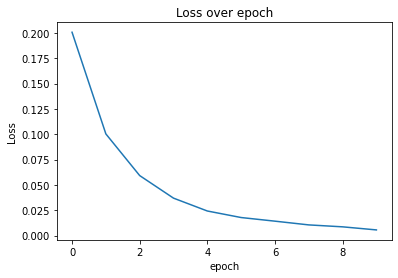

In [0]:
## Setup model
CUDA_ENABLED = True
FULL_FINETUNING = True

model = BertForTokenClassification.from_pretrained("bert-base-cased", num_labels=len(tag_index))
if CUDA_ENABLED:
    model = model.cuda()


if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
    
optimizer = Adam(optimizer_grouped_parameters, lr=2e-5)

## Training
epochs = 10
max_grad_norm = 1.0
loss_history_train = []

for _ in range(epochs):
    start_time = time.time()
    # TRAIN loop
    model.train()
    train_loss = 0
    num_train_steps = 0
    for step, batch in enumerate(train_loader):
        num_train_steps += 1
        # add batch to gpu
        if CUDA_ENABLED:
            batch = tuple(t.cuda() for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        train_loss += loss.item()
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
        
    # print train loss per epoch
    run_time = time.time() - start_time
    lose_avg_train = train_loss/num_train_steps
    loss_history_train.append(lose_avg_train)
    print("Train loss:",lose_avg_train,"Run time:",run_time)
    
#Plot loss
plt.figure(1)
plt.plot(range(len(loss_history_train)), loss_history_train)
plt.title('Loss over epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show() 

In [0]:
## Prediction Dev
start_time = time.time()
model.eval()
dev_prediction = []
dev_loss = 0
dev_accuracy = 0
num_dev_steps = 0

for batch in dev_loader:
    num_dev_steps += 1
    
    if CUDA_ENABLED:
        batch = tuple(t.cuda() for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        tmp_dev_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        
    logits = logits.detach().cpu().numpy()
    pred_ids = np.array([list(p) for p in np.argmax(logits, axis=2)])
    dev_prediction.extend(pred_ids)
    
    label_ids = b_labels.cpu().numpy()

    tmp_dev_accuracy = np.sum(pred_ids.flatten() == label_ids.flatten()) / len(label_ids.flatten())

    dev_loss += tmp_dev_loss.mean().item()
    dev_accuracy += tmp_dev_accuracy

print("Dev loss:",dev_loss/num_dev_steps)
print("Dev accuracy:",dev_accuracy/num_dev_steps)
print("Run time:",time.time() - start_time)

Dev loss: 0.16773219012344878
Dev accuracy: 0.9758716397849464
Run time: 6.533116340637207


In [0]:
#convert prediction ids back to tags
def id2tag(pred_tag_ids, attention_mask, origin_mask):
    #pred_tag_ids = dev_prediction
    #attention_mask = dev_attention
    #origin_mask = dev_origin
    pred_sent_tags = []
    gotcha = []

    for i, sentence in enumerate(attention_mask):
        sentence_tags=[]
        for j, attention in enumerate(sentence):
            if attention == 1:
                if origin_mask[i][j]:
                    tag_id = pred_tag_ids[i][j]
                    tag = index_tag[tag_id]
                    sentence_tags.append(tag)
                if j == MAX_LENGTH-1:
                    pred_sent_tags.append(sentence_tags)
                    break
            elif attention == 0:
                pred_sent_tags.append(sentence_tags)
                break

    #convert sentences to continous result array
    pred_tags = []
    for sentence in pred_sent_tags:
        pred_tags.extend(sentence)
        pred_tags.append('')

    return pred_tags

dev_pred = id2tag(dev_prediction, dev_attention, dev_origin)

# Write to CSV
def write2file(prediction):
    pd.DataFrame(prediction).to_csv(path_or_buf='prediction.txt', index=False, header=False, sep='\t', line_terminator='\n')
    f = open('prediction.txt', 'r')
    text = f.read()
    f.close()
    text = text.replace("\"\"","")
    f = open('prediction.txt', 'w')
    f.write(text)
    f.close()

write2file(dev_pred)


In [0]:
## Prediction Test
model.eval()
test_prediction = []
num_test_steps = 0

for batch in test_loader:
    num_test_steps += 1
    
    if CUDA_ENABLED:
        batch = tuple(t.cuda() for t in batch)
    b_input_ids, b_input_mask = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        
    logits = logits.detach().cpu().numpy()
    pred_ids = np.array([list(p) for p in np.argmax(logits, axis=2)])
    test_prediction.extend(pred_ids)

#convert id to tags
test_pred = id2tag(test_prediction, test_attention, test_origin)

#write to file
write2file(test_pred)

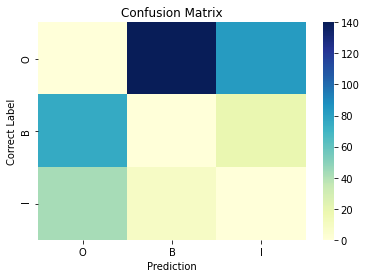

In [0]:
#Confusion Matrix
def plot_confusion_matrix(y_pred, y_true, tag_index):
    tag_list = list(tag_index.keys())
    confused_matrix = confusion_matrix(y_pred, y_true, labels=tag_list)
    for i in range(confused_matrix.shape[0]):
        confused_matrix[i][i] = 0

    ax = sns.heatmap(confused_matrix, cmap="YlGnBu", xticklabels=tag_list, yticklabels=tag_list)
    plt.title('Confusion Matrix')
    plt.xlabel('Prediction')
    plt.ylabel('Correct Label')
    plt.show()

plot_confusion_matrix(dev_pred, dev_tags, tag_index)
    